In [1]:
!pip3 install tflearn

In [0]:
import numpy as np
from scipy.misc import imread, imresize
from glob import glob # helps find files in a folder
import os  # to navigate through filesystem
from google.colab import drive # needed to connect to drive
import matplotlib.pyplot as plt # need to plot images
import os, sys
import glob
from scipy.misc import imread, imresize, imshow
from tflearn.layers.core import input_data
from tflearn.layers.conv import global_avg_pool
from tflearn.layers.core import fully_connected
from tflearn.layers.estimator import regression

In [3]:
drive.mount('/content/drive') # mounts drive to colaboratory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# navigate through filesystem to class folder
os.chdir('drive/My Drive/DeepLearningFall2018/')

In [5]:
os.listdir() # list all files and folders in this location

['Homework1',
 'In Class Work',
 'Notes',
 'linear_data.csv',
 'Deep Learning.gdoc',
 'Homework2',
 'cifar-10-batches-py',
 'Homework 3.gdoc',
 'iris_flower_data.csv',
 'Midterm_Practice2.ipynb',
 'MIdterm',
 'Untitled0.ipynb',
 'Multilayer_perceptions_ShirleyXu.ipynb',
 'Perceptrons_Example_MichaelTeti.ipynb',
 'Midterm_Practice.ipynb',
 'cifar-10_CNN.data-00000-of-00001',
 'cifar-10_CNN.index',
 'cifar-10_CNN.meta',
 'Midterm_Exam_ShirleyXu.ipynb',
 'residual_block.py',
 'residual_block.ipynb',
 '__pycache__',
 'Generative_Adversarial_Network_ShirleyXu.ipynb',
 'Plants.gslides',
 'Paper Example.gdoc',
 'Final Project',
 'Plant Data',
 'Orange Data',
 'Plant_ResNet.data-00000-of-00001',
 'Plant_ResNet.index',
 'Plant_ResNet.meta',
 'Orange_ResNet.data-00000-of-00001',
 'Orange_ResNet.index',
 'Orange_ResNet.meta',
 'checkpoint',
 'Orange2.0_ResNet.data-00000-of-00001',
 'Orange2.0_ResNet.index',
 'Orange2.0_ResNet.meta',
 'Graph']

In [0]:
from residual_block import *  # import everything from the residual_block notebook

In [0]:
def img_reader(dir, imsz, file_ex=None, sort=False):
    ''' A function that reads in images contained
        in each folder in dir, resizes them to
        imsz[0] x imsz[1], and attaches a label to
        each image based on the folder it came from.

        Args:
             dir: directory where the image folders are
                  located.
             imsz: a list of length 2, where each number
                   represents the height and width each
                   image will be resized to. If all images
                   are the same size and don't need to be
                   resized, just put the size they already
                   are.
              file_ex: if the images you want to compile
                       are all of the same extension and/or
                       there are other file types in the
                       folders that you don't want to read,
                       you can include the extension as file_ex.
                       Example, file_ex = '.jpg'
    '''
    
    main_dir = os.getcwd()
    
    if file_ex is None:
        file_ex = '*'
    else:
        file_ex = '*' + file_ex

    folders = os.listdir(dir)
    os.chdir(dir)
    num_ims=sum([len(files) for r, d, files in os.walk(os.getcwd())])
    imgs = np.zeros([num_ims, imsz[0], imsz[1], 3])
    labels = np.zeros([num_ims, 1])

    for subdir, folder in enumerate(folders):
        os.chdir(dir + '/' + folder)
        files = glob.glob(file_ex)
        if sort:
            files.sort()

        for i, file in enumerate(files):
            if os.path.isfile(file):
                img = imread(file)
                img = imresize(img, [imsz[0], imsz[1]])
                imgs[i, ...] = img
                labels[i, 0] = subdir

    os.chdir(main_dir)            
    return imgs, labels

In [8]:
os.getcwd() # see what folder you are in

'/content/drive/My Drive/DeepLearningFall2018'

In [0]:
os.chdir('Orange Data') # go into Data folder where my two folders are with the images

In [10]:
os.listdir()

['Orange', 'Moldy Orange']

In [11]:
X, Y = img_reader(os.getcwd(), [150, 150])  # get images and labels as X and Y 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [0]:
# make labels into vectors with two categories since I have two classes in my dataset
from tflearn.data_utils import to_categorical
Y = to_categorical(Y, 2)

In [13]:
print(X.shape)

(250, 150, 150, 3)


In [0]:
# make data normalized 
X -= np.mean(X) # subtract mean 
X /= np.std(X)  # divide by standard deviation

In [0]:
os.chdir('..') # go back to deep learning class folder

In [16]:
!pip install tensorboardcolab
from tensorboardcolab import *

Using TensorFlow backend.


In [27]:
tf.reset_default_graph()
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://babbaf95.ngrok.io


In [0]:
# create the input layer for the network
input_layer = input_data([None, 150, 150, 3])

# first convolution --- 75 x 75 x 64
conv1 = conv_2d(input_layer, 64, 7, strides=2, activation='relu')

# max pooling --- 37 x 37 x 64
pool1 = max_pool_2d(conv1, 3, 2)

# residual blocks 1-3 --- 37 x 37 x 64
residual_block1 = residual_block(pool1, # input to this layer
                                 64, # number of features to look for
                                 3, # filter size
                                 3) # number of residual blocks

# residual blocks 4-7 --- 18 x 18 x 128
residual_block2 = residual_block(residual_block1, # input 
                                 128, # num. features to look for
                                 3, # filter size
                                 4, # number of blocks
                                 2) # stride length 

# residual blocks 8-13 --- 9 x 9 x 256
residual_block3 = residual_block(residual_block2,
                                 256,
                                 3,
                                 6, 
                                 2)

# residual blocks 14-16 --- 4 x 4 x 512
residual_block4 = residual_block(residual_block3,
                                 512,
                                 3,
                                 3,
                                 2)

# global average pooling --- 512
gap = global_avg_pool(residual_block4)

# output layer
output_layer = fully_connected(gap, 2, activation='softmax')

In [0]:
# describe optimization 
optimizer = regression(output_layer, optimizer='adam', learning_rate=0.001)

In [0]:
# build the model
model = tflearn.DNN(optimizer, tensorboard_verbose=2, tensorboard_dir='./Graph')

In [31]:
# training
model.fit(X,
          Y,
          batch_size=32,
          n_epoch=100,
          validation_set=0.1,
          show_metric=True,
          snapshot_step=100, 
          run_id='run1')

Training Step: 799  | total loss: 1.38713 | time: 12.802s
| Adam | epoch: 100 | loss: 1.38713 - acc: 0.5130 -- iter: 224/225
Training Step: 800  | total loss: 1.38712 | time: 15.441s
| Adam | epoch: 100 | loss: 1.38712 - acc: 0.4617 | val_loss: 1.39118 - val_acc: 0.0000 -- iter: 225/225
--


In [22]:
model.save('Orange2.0_ResNet') # save as whatever name you want

INFO:tensorflow:/content/drive/My Drive/DeepLearningFall2018/Orange2.0_ResNet is not in all_model_checkpoint_paths. Manually adding it.


In [0]:
num_classes = 2
conf_mat = np.zeros([num_classes, num_classes])

In [0]:
for val_sample in range(X.shape[0]): # loop through validation samples
  x = X[val_sample, ...]  # that sample
  y = Y[val_sample, ...] # that sample's label
  
  y = np.argmax(y)  # get the position of the 1 in the label vector
  
  output = model.predict(x[None, ...]) # have the model predict on the sample
  
  output = np.argmax(output) # get the class based on highest value in the output vector
  
  conf_mat[y, output] += 1

In [25]:
conf_mat

array([[  0., 250.],
       [  0.,   0.]])

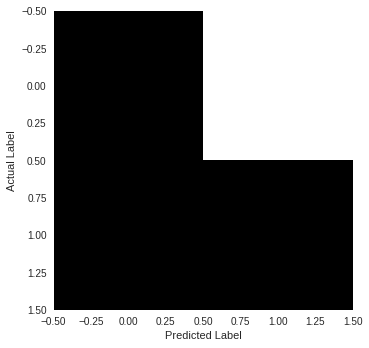

In [26]:
plt.imshow(conf_mat, cmap='gray')
plt.grid(False)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()